<a href="https://colab.research.google.com/github/alimoorreza/cs195-fall24-notes/blob/main/cs195_alexnet_dissection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS195: Day07

### CS195: Computer Vision, Fall 2024

Monday, September 23rd, 2024

📆 [Course Schedule](https://analytics.drake.edu/~reza/teaching/cs195_fall24/cs195_schedule.html) | 📜 [Syllabus](https://analytics.drake.edu/~reza/teaching/cs195_fall24/cs195_syllabus_sp24.pdf)


In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
import json
import numpy as np

# util function:
def get_imagenet_mean_std_normalized():
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    return mean, std

def load_json_file(file_path):

  data = {}
  with open(file_path, 'r') as file:
    data = json.load(file)

  return data

def write_json_file(file_path):

  data = {}
  with open(file_path, 'w') as file:
    data = json.dump(data, file)

  return data

# **Creating AlexNet network architecture**
> ## **Loading model's pretrained weights from PyTorch library**

In [1]:
import torch
import torch.nn as nn
from torchvision import models

import PIL
from PIL import Image
import json
import torchvision
import torchvision.transforms as T

import sys
import matplotlib.pyplot as plt
import scipy.io
import os

import pdb

from torchvision import transforms, datasets

# You can give any name to your new network, e.g., AlexNet.
# You should load the pretrained AlexNet model from torchvision.models.
# This model was trained on over a million real-world images from ImageNet.


class AlexNet(nn.Module):

    def __init__(self, num_classes, pretrained=True):

        super(AlexNet, self).__init__()

        # download PyTorch's own implementation of AlexNet model trained on ImageNet dataset
        net             = models.alexnet(pretrained=True)


        # retained weightes for convolutional, pooling, linear layers from AlexNet
        self.features   = net.features
        self.avgpool    = net.avgpool
        self.classifier = net.classifier

        # IMPORTANT: "If you need to fine-tune this network for your own dataset,
        # the simplest modification is to replace the last layer in self.classifier with
        # the updated AlexNet has the desired number of output classes: 'num_classes'
        # self.classifier[-1] = nn.Linear(4096, num_classes) # only this last layer's weights will be trained from scratch


    def forward(self, x):

        print("shape of input: ", x.shape)
        x = self.features(x)
        print("output shape (self.features): ", x.shape)
        x = self.avgpool(x)
        print("output shape (self.avgpool): ", x.shape)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        print("output shape (self.classifier): ", x.shape)
        return x


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
number_of_classes = 1000
model             = AlexNet(number_of_classes)
model.to(device)


device =  cpu


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# **Doing single forward pass on AlexNet using a sample image**

In [8]:
TEST_IMAGE_SIZE_W = 227
TEST_IMAGE_SIZE_H = 227
file_path         = '/content/drive/MyDrive/cs195_fall24/classification/imagenet_1000_classes.json'
label_map         = load_json_file(file_path)
mean, std         = get_imagenet_mean_std_normalized()
print(label_map)
print(f"ImageNet: mean: {mean}, std: {std}")

# CNN architectures such as AlexNet, VGGNet, and ResNet has been pre-trained using the ImageNet dataset.
# You need to normalize each image with the given mean and standard deviation before doing the forward-pass on these networks.
transform = transforms.Compose([
    transforms.Resize((TEST_IMAGE_SIZE_W, TEST_IMAGE_SIZE_H)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std) # ImageNet: mean (R, G, B) and standard deviation (R, G, B)
])



{'0': 'tench, Tinca tinca', '1': 'goldfish, Carassius auratus', '2': 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', '3': 'tiger shark, Galeocerdo cuvieri', '4': 'hammerhead, hammerhead shark', '5': 'electric ray, crampfish, numbfish, torpedo', '6': 'stingray', '7': 'cock', '8': 'hen', '9': 'ostrich, Struthio camelus', '10': 'brambling, Fringilla montifringilla', '11': 'goldfinch, Carduelis carduelis', '12': 'house finch, linnet, Carpodacus mexicanus', '13': 'junco, snowbird', '14': 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', '15': 'robin, American robin, Turdus migratorius', '16': 'bulbul', '17': 'jay', '18': 'magpie', '19': 'chickadee', '20': 'water ouzel, dipper', '21': 'kite', '22': 'bald eagle, American eagle, Haliaeetus leucocephalus', '23': 'vulture', '24': 'great grey owl, great gray owl, Strix nebulosa', '25': 'European fire salamander, Salamandra salamandra', '26': 'common newt, Triturus vulgaris', '27': 'eft', '28': '

### **Run the pretrained model on a random image to test its classification ability**
> I have uploaded the images of `cat,` `dog,` and `bike` to Blackboard.

> You can download those images and upload them to your workspace. Alternatively, you can download random images of a `cat,` `dog,` or `any other class of your choice` and test them using AlexNet.


In [ ]:
img = PIL.Image.open('/content/drive/MyDrive/cs195_fall24/classification/inference_img/random_dog1.jpg')
#img = PIL.Image.open('/content/drive/MyDrive/cs195_fall24/classification/inference_img/random_dog2.jpg')
#img = PIL.Image.open('/content/drive/MyDrive/cs195_fall24/classification/inference_img/random_cat1.jpg')
#img = PIL.Image.open('/content/drive/MyDrive/cs195_fall24/classification/inference_img/random_cat2.jpg')
#img = PIL.Image.open('/content/drive/MyDrive/cs195_fall24/classification/inference_img/random_bike1.jpg')


print(f"shape of img: {img.size}")


shape of img: (1024, 683)


In [ ]:
img_tensor          = transform(img).unsqueeze(0).to(device)
raw_output          = model(img_tensor)
output_prob         = torch.softmax(raw_output, dim=1)
output_prob_numpy   = output_prob.data.numpy()[0]


shape of input:  torch.Size([1, 3, 227, 227])
output shape (self.features):  torch.Size([1, 256, 6, 6])
output shape (self.avgpool):  torch.Size([1, 256, 6, 6])
output shape (self.classifier):  torch.Size([1, 1000])


In [ ]:
print(f"Sum of all predicted probabilities: {np.sum(output_prob_numpy)}")
print(f"Probability of class-0: {output_prob_numpy[0]}")

Sum of all predicted probabilities: 1.0
Probability of class-0: 1.6807833336934808e-12


label map: {'0': 'tench, Tinca tinca', '1': 'goldfish, Carassius auratus', '2': 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', '3': 'tiger shark, Galeocerdo cuvieri', '4': 'hammerhead, hammerhead shark', '5': 'electric ray, crampfish, numbfish, torpedo', '6': 'stingray', '7': 'cock', '8': 'hen', '9': 'ostrich, Struthio camelus', '10': 'brambling, Fringilla montifringilla', '11': 'goldfinch, Carduelis carduelis', '12': 'house finch, linnet, Carpodacus mexicanus', '13': 'junco, snowbird', '14': 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', '15': 'robin, American robin, Turdus migratorius', '16': 'bulbul', '17': 'jay', '18': 'magpie', '19': 'chickadee', '20': 'water ouzel, dipper', '21': 'kite', '22': 'bald eagle, American eagle, Haliaeetus leucocephalus', '23': 'vulture', '24': 'great grey owl, great gray owl, Strix nebulosa', '25': 'European fire salamander, Salamandra salamandra', '26': 'common newt, Triturus vulgaris', '27': 'ef

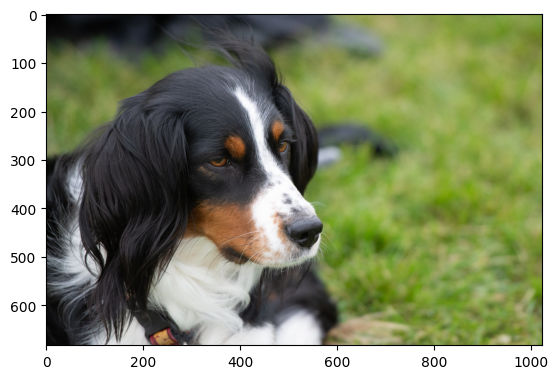

In [ ]:
# results after the completion of the forward pass through AlexNet
#print(f"raw probability: {output_prob}")
print(f"label map: {label_map}")
K             = 10
topk          = torch.topk(output_prob, k=K)
topk_prob     = topk.values[0]
topk_indices  = topk.indices[0]
topk_indices  = topk_indices.data.numpy()
print(f"top4_classes are as follow: \n{topk_indices}")
labels        = "{:75s}".format("predicted label from AlexNet")
prob          = "{}".format("probability")
print("\n{:75s}".format("--------------------------------------------------------------------------------------\n"), labels, prob,"\n{:75s}".format("--------------------------------------------------------------------------------------"))

for i in range(K):
    labels  = label_map[str(topk_indices[i])]
    labels  = "{:75s}".format(labels)
    prob    = "{:.4f}".format(float(topk_prob[i]))
    print(labels, prob)

print("{:75s}".format("--------------------------------------------------------------------------------------"))
plt.imshow(img)


#**Group task#1**
> ### **Task 1: Modify the AlexNet network architecture by updating the last layer's structure and replace the pretrained weights of the last layer with new random weights.**

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
import pdb

# You can give any name to your new network, e.g., AlexNet.
# You should load the pretrained AlexNet model from torchvision.models.
# This model was trained on over a million real-world images from ImageNet.


class AlexNet(nn.Module):

    def __init__(self, num_classes, pretrained=True):

        super(AlexNet, self).__init__()

        # download PyTorch's own implementation of AlexNet model trained on ImageNet dataset
        net             = models.alexnet(pretrained=True)


        # retained weightes for convolutional, pooling, linear layers from AlexNet
        self.features   = net.features
        self.avgpool    = net.avgpool
        self.classifier = net.classifier

        # -----------------------MODIFICATION-------------------------------------
        # IMPORTANT: If you need to fine-tune this network for your own dataset,
        # the simplest modification is to replace the last layer in self.classifier with
        # the updated AlexNet has the desired number of output classes: 'num_classes'
        self.classifier[-1] = nn.Linear(4096, num_classes) # only this last layer's weights will be trained from scratch
        # ------------------------------------------------------------------------


    def forward(self, x):

        print("shape of input: ", x.shape)
        x = self.features(x)
        print("output shape (self.features): ", x.shape)
        x = self.avgpool(x)
        print("output shape (self.avgpool): ", x.shape)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        print("output shape (self.classifier): ", x.shape)
        return x


> ### **Task 2: Run the pretrained model on a random image to test its classification ability**

> Essentially, repeat the experiment we did earlier.


In [ ]:
# your code
# ...
# ...
# ...

> ### **Task 3: Summarize your observations and discuss them with your group members.**

>> Do you notice anything unusual, or does everything seem normal?

>> Explain your reasoning.


##**your answer**

# ...
# ...
# ...

#**Group task#2**
> ### **Change the network layout of AlexNet so that you could see the size of individual features after each intermediate layer**

> Define the network

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
import pdb

class AlexNet(nn.Module):

    def __init__(self, num_classes, pretrained=True):

        super(AlexNet, self).__init__()

        net             = models.alexnet(pretrained=True)
        # further dissecting attribute: net.features

        self.conv1      = net.features[0]
        self.relu1      = net.features[1]
        self.maxpool1   = net.features[2]

        self.conv2      = net.features[3]
        self.relu2      = net.features[4]
        self.maxpool2   = net.features[5]

        self.conv3      = net.features[6]
        self.relu3      = net.features[7]
        # Notice, there is no pooling layer after the 3rd convolution

        self.conv4      = net.features[8]
        self.relu4      = net.features[9]
        # Notice, there is no pooling layer after the 4rd convolution

        self.conv5      = net.features[10]
        self.relu5      = net.features[11]
        self.maxpool3   = net.features[12]


        # adaptive average pooling
        '''
        (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
        '''
        self.avgpool    = net.avgpool


        # further dissecting attribute: net.classifier
        # fully connected layers sequentially placed towards the end
        self.fc6      = net.classifier[0] # or create a new layer if you want to learn from scratch: nn.Linear(256 * 6 * 6, 4096)
        self.relu6    = net.classifier[1] # or create a new layer: nn.ReLU(True)
        self.dropout1 = net.classifier[2] # or create a new layer: nn.Dropout()

        self.fc7      = net.classifier[3] # or create a new layer if you want to learn from scratch: nn.Linear(4096, 512)
        self.relu7    = net.classifier[4] # or create a new layer: nn.ReLU(True)
        self.dropout2 = net.classifier[5] # or create a new layer: nn.Dropout()

        self.fc8     = nn.Linear(4096, num_classes) # create a linear layer with a dense connection of 4096 x num_classess neurons


    def forward(self, x):

        print(f"[{x.shape[1:]}] INPUT")
        x = self.conv1(x)
        x = self.relu1(x)
        print(f"[{x.shape[1:]}] CONV1: 64 convolutional filters each with a shape=11x11, stride=4, pad=2")
        x = self.maxpool1(x)
        print(f"[{x.shape[1:]}] MAX POOL1: 3x3 max pooling filters with stride=2, pad=0")

        x = self.conv2(x)
        x = self.relu2(x)
        print(f"[{x.shape[1:]}] CONV2: 192 convolutional filters each with a shape=5x5, stride=1, pad=2")
        x = self.maxpool2(x)
        print(f"[{x.shape[1:]}] MAX POOL2: 3x3 max pooling filters with stride=2, pad=0")

        x = self.conv3(x)
        x = self.relu3(x)
        print(f"[{x.shape[1:]}] CONV3: 384 convolutional filters each with a shape=3x3, stride=1, pad=1")

        x = self.conv4(x)
        x = self.relu4(x)
        print(f"[{x.shape[1:]}] CONV4: 256 convolutional filters each with a shape=3x3, stride=1, pad=1")

        x = self.conv5(x)
        x = self.relu5(x)
        print(f"[{x.shape[1:]}] CONV5: 256 convolutional filters each with a shape=3x3, stride=1, pad=1")
        x = self.maxpool3(x)
        print(f"[{x.shape[1:]}] MAX POOL3: 3x3 max pooling filters with stride=2, pad=0")

        x = self.avgpool(x)
        print(f"[{x.shape[1:]}] AVG POOL: fixed output size [width x height] ")
        x = torch.flatten(x, 1)

        x = self.fc6(x)
        x = self.relu6(x)
        print(f"[{x.shape[1:]}] FC6: neurons")
        x = self.dropout1(x)

        x = self.fc7(x)
        x = self.relu7(x)
        print(f"[{x.shape[1:]}] FC7: neurons")
        x = self.dropout2(x)

        x = self.fc8(x)
        print(f"[{x.shape[1:]}] FC8: neurons")

        return x



device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
number_of_classes = 1000
model             = AlexNet(number_of_classes)
model.to(device)


device =  cpu


AlexNet(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (relu1): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU(inplace=True)
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU(inplace=True)
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU(inplace=True)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU(inplace=True)
  (maxpool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (fc6): Dropout(p=0.5, inplace=False)
  (relu6): Linear(in_features=9216, out_features=4096, bias=True)
  (dropout1): ReLU(inplac

> Do the forward pass through AlexNet using an image

In [ ]:
img = PIL.Image.open('/content/drive/MyDrive/cs195_fall24/classification/inference_img/random_dog1.jpg')
img_tensor    = transform(img).unsqueeze(0).to(device)
raw_output    = model(img_tensor)
output_prob   = torch.softmax(raw_output, dim=1)


[torch.Size([3, 227, 227])] INPUT
[torch.Size([64, 56, 56])] CONV1: 64 convolutional filters each with a shape=11x11, stride=4, pad=2
[torch.Size([64, 27, 27])] MAX POOL1: 3x3 max pooling filters with stride=2, pad=0
[torch.Size([192, 27, 27])] CONV2: 192 convolutional filters each with a shape=5x5, stride=1, pad=2
[torch.Size([192, 13, 13])] MAX POOL2: 3x3 max pooling filters with stride=2, pad=0
[torch.Size([384, 13, 13])] CONV3: 384 convolutional filters each with a shape=3x3, stride=1, pad=1
[torch.Size([256, 13, 13])] CONV4: 256 convolutional filters each with a shape=3x3, stride=1, pad=1
[torch.Size([256, 13, 13])] CONV5: 256 convolutional filters each with a shape=3x3, stride=1, pad=1
[torch.Size([256, 6, 6])] MAX POOL3: 3x3 max pooling filters with stride=2, pad=0
[torch.Size([256, 6, 6])] AVG POOL: fixed output size [width x height] 
[torch.Size([4096])] FC6: neurons
[torch.Size([4096])] FC7: neurons
[torch.Size([1000])] FC8: neurons
